In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [5]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cpu
matplotlib==3.6.2


In [6]:
#load data
data = pd.read_csv("E:\GitHub\MasterWork\Data\S&P 500 Historical Data00-20.csv")

In [7]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [8]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [9]:
data.index = data.index[::-1]

In [10]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [11]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [12]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [13]:
#change indexes
special_data.set_index('Date', inplace=True)

In [14]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [15]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


In [16]:
train = special_data.Price[:(int)(0.7 * len(special_data))]
val = special_data.Price[(int)(0.7 * len(special_data)):(int)(0.7 * len(special_data))+5]
test = special_data.Price[(int)(0.7 * len(special_data))+5:]

In [17]:
len(train)

704

In [18]:
len(val)

5

In [19]:
len(test)

297

In [20]:
val.head()

Date
2012-10-17    1460.91
2012-10-18    1457.34
2012-10-19    1433.19
2012-10-22    1433.82
2012-10-23    1413.11
Name: Price, dtype: float64

In [21]:
test.head()

Date
2012-10-24    1408.75
2012-10-25    1412.97
2012-10-26    1411.94
2012-10-31    1412.16
2012-11-01    1427.59
Name: Price, dtype: float64

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(train.values.reshape(-1, 1))
val_arr = scaler.transform(val.values.reshape(-1, 1))
test_arr = scaler.transform(test.values.reshape(-1, 1))

In [23]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [24]:
from torch.autograd import Variable

seq_len = 700

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [25]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

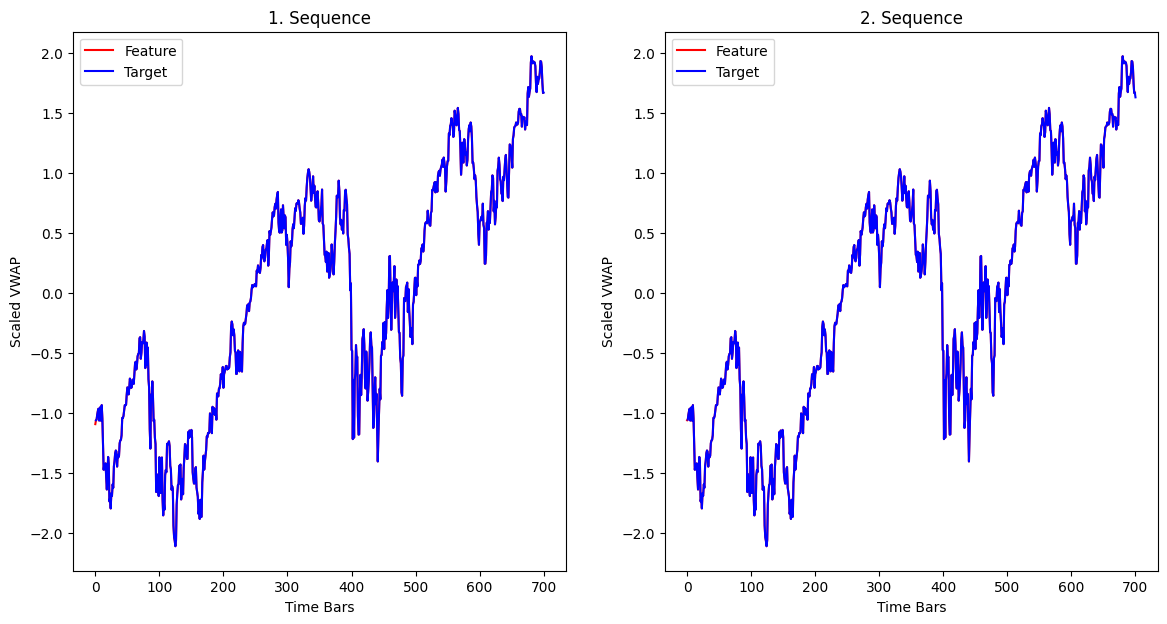

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [27]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [40]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                self.scheduler.step()
                train_loss /= batch
                self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
                val_loss /= batch
                self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
                test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [41]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [42]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [43]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [44]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

IndexError: list index out of range

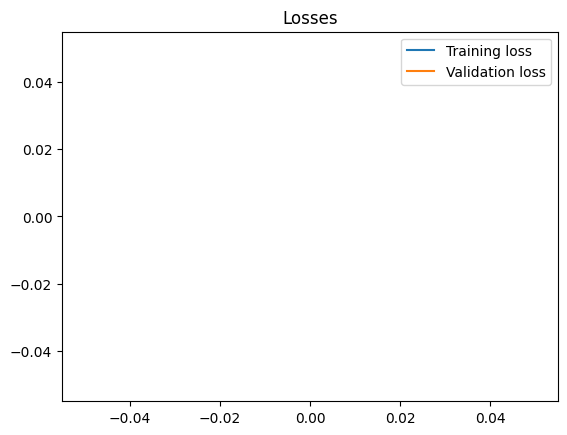

In [45]:
optimization_1.plot_losses()

In [46]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

In [50]:
x_sample = x_test[0].reshape(1, -1)
y_sample = test.Price[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

In [47]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)

In [48]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

IndexError: list index out of range

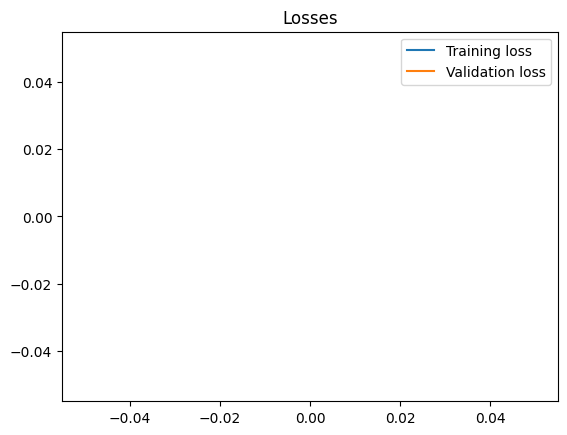

In [49]:
optimization_2.plot_losses()

In [ ]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))